# Initial Model Experiments with SciPy

As requested in the test spec, I am including a simple notebook here to show how the deployed model performs overall. I chose to go ahead with a SciPy mini transformer from the get-go instead of using very fuzzy methods like Levenshtein distance or fuzzy word matching. I think for the scale of the problem, the results are actually quite good without even fitting the model to the specific dataset.

Just to summarize the problem statement, we expect that a query comes with a customer ID, and we need to give a list of the top N recommendations, based on the interaction history of that customer.

## Methodology:

The high-level approach to giving recommendation scores is:

1. Use a model to embed each product name with a meaningful vector that captures the semantics and contents of that product name.

2. We are skipping low-level heuristic matching methods like Levenshtein matching; they are more explainable but generally outperformed by content-based NLP models.

3. When a customer ID query is received, we grab each product in that customer’s history and multiply it with all the embeddings we have in our dataset of product names.

4. We return the product names with the top N scores. If the dataset product names share semantics with the product names already associated with the queried customer ID, they will have a higher score.

## Some Notes on the Implementation

1. The embeddings are relatively quick to produce, even for the large dataset provided. It took ~10 minutes on a CPU virtual machine to measure the embeddings for all the transactions.

2. I am caching a dump of the embeddings to make the service quicker to host.

## Results Overview

1. From a qualitative study of the retrieved recommendations, we see that the response recommendation tables do have similar semantics when compared with the products associated with each inspected customer ID.

2. By inspecting the histogram of recall values, the recalls seem to be approaching a uniform distribution, with a slight bias towards lower values.

3. Also note that the recall values and histogram were measured on a sample of circa 500 samples.

## Some Notes on the Dataset:

1. The dataset is highly biased towards customers with only one interaction in their history.
2. The bias also holds true for product names; most product names show up only once.
3. There is less bias with Event Type; most are "Cart" or "Purchased," but it's more uniformly distributed.

That's it, and thanks for the clear test!


In [ ]:
# !pip install pandas numpy scipy matplotlib sentence-transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer

# Load dataset
df = pd.read_csv("../data/sample_data.csv")

# Convert customer_id to categorical integer labels
df["customer_id"] = df["customer_id"].astype("category").cat.codes
df["product_id"] = df["product_id"].astype("category").cat.codes

# Remove duplicate rows with identical values across all columns
df = df.drop_duplicates()

# Sort DataFrame by ascending customer_id
df = df.sort_values(by="customer_id", ascending=True).reset_index(drop=True)

DATASET_SIZE = len(df)

# Display first few rows of cleaned dataset
df.head()


,index,product_id,customer_id,product_name,Event_Date,Event
0,10233307,121161,0,ماي تيتشر كونكت بلس صف خامس ابتدائي ترم 1 2023,2023-02-11 12:26:43+00:00,cart
1,164956,54269,1,مفتوح لمدة 3 اشهر STC,2023-03-21 09:50:26+00:00,cart
2,610418,76968,2,150 مل موركون البرازيلي للشعر المتوسط الخشونه,NaN,wishlist
3,3539779,21900,3,ايسنس ماسكرا لاش برينسس فالس 12مل,2023-01-18 20:37:58+00:00,cart
4,2375201,16623,4,كيس حناء مطحون 5 كيلو,2023-03-23 13:45:25+00:00,cart


customer_id
358595    39
426705    36
265093    33
14241     31
268258    30
          ..
155471     1
155470     1
155469     1
155468     1
433786     1
Name: count, Length: 433787, dtype: int64


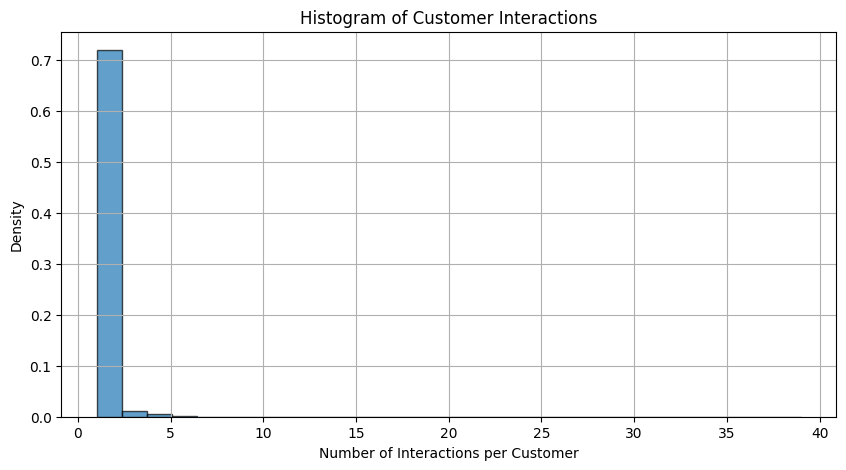

In [4]:
# Count interactions per customer
customer_interaction_counts = df["customer_id"].value_counts()
print(customer_interaction_counts)
# Check unique values to determine bin size
num_bins = max(10, len(customer_interaction_counts.unique()))

# Plot histogram with adjusted bins
plt.figure(figsize=(10, 5))
plt.hist(customer_interaction_counts, bins=num_bins, alpha=0.7, edgecolor="black", density=True)
plt.xlabel("Number of Interactions per Customer")
plt.ylabel("Density")
plt.title("Histogram of Customer Interactions")
plt.grid(True)
plt.show()


product_id
378       2556
125       2282
490       2128
273       1181
129       1115
          ... 
1518         1
166428       1
152861       1
47128        1
71090        1
Name: count, Length: 200325, dtype: int64


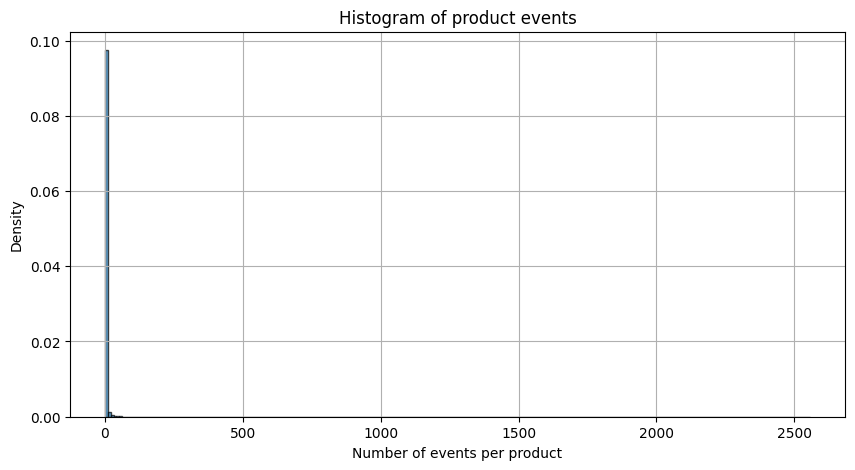

In [ ]:
# Count interactions per customer
product_id_counts = df["product_id"].value_counts()
print(product_id_counts)
# Check unique values to determine bin size
num_bins = len(product_id_counts.unique()) # max(10, len(product_id_counts.unique()))

# Plot histogram with adjusted bins
plt.figure(figsize=(10, 5))
plt.hist(product_id_counts, bins=num_bins, alpha=0.7, edgecolor="black", density=True)
plt.xlabel("Number of events per product")
plt.ylabel("Density")
plt.title("Histogram of product events")
plt.grid(True)
plt.show()


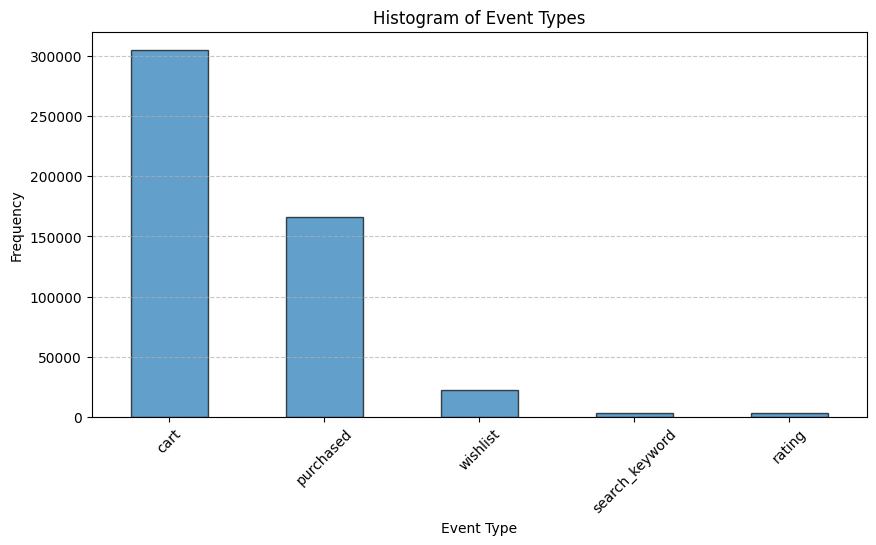

In [ ]:
# Count occurrences of each event type
event_counts = df["Event"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 5))
event_counts.plot(kind="bar", alpha=0.7, edgecolor="black")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.title("Histogram of Event Types")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


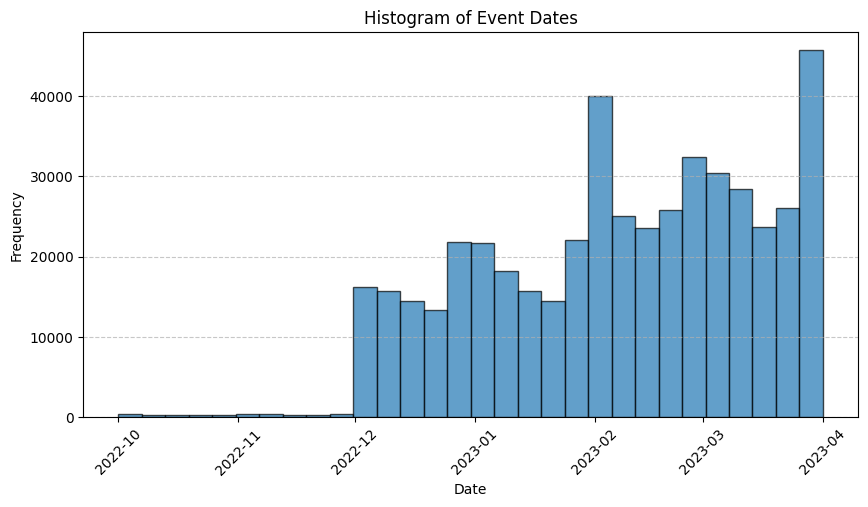

In [ ]:
# Convert Event_Date to datetime
df["Event_Date"] = pd.to_datetime(df["Event_Date"], errors="coerce")  # Handle invalid dates safely

# Drop NaT (invalid timestamps)
df = df.dropna(subset=["Event_Date"])

# Plot histogram of event timestamps
plt.figure(figsize=(10, 5))
plt.hist(df["Event_Date"], bins=30, alpha=0.7, edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Histogram of Event Dates")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Initialize sentence transformer model
# embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode product names into vectors
# df["embedding"] = df["product_name"].astype(str).apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))


import os
import pickle
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

EMBEDDINGS_FILE = "../embeddings/embeddings.pkl"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

embedding_model = SentenceTransformer(MODEL_NAME)

try:
    with open(EMBEDDINGS_FILE, "rb") as f:
        embeddings_dict = pickle.load(f)
    
    df["embedding"] = df["product_name"].map(embeddings_dict)

    if df["embedding"].isnull().sum() > 0:
        raise ValueError("Some embeddings are missing, recalculating...")

    print("✅ Loaded embeddings from file.")

except (FileNotFoundError, ValueError, EOFError, pickle.UnpicklingError):
    print("⚠️ Embeddings file not found or incomplete. Computing embeddings...")

    df["embedding"] = df["product_name"].astype(str).apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))
    embeddings_dict = df.set_index("product_name")["embedding"].to_dict()

    with open(EMBEDDINGS_FILE, "wb") as f:
        pickle.dump(embeddings_dict, f)

    print("✅ Computed and saved embeddings.")


In [ ]:
def get_top_5_matching_products(customer_id):
    """Find the top 5 products in the dataset that have the highest average similarity
    when matched against all products associated with the given customer_id.
    """
    # Get all product embeddings associated with the customer
    customer_products = df[df["customer_id"] == customer_id]

    if customer_products.empty:
        return {"error": "No products found for this customer"}

    customer_embeddings = np.array(customer_products["embedding"].tolist())

    # Compute similarity of each product in the dataset against all of the customer's products
    product_scores = {}

    for _, row in df.iterrows():
        product_name = row["product_name"]
        product_embedding = row["embedding"]

        # Compute average similarity across all customer-associated products
        similarity_scores = [1 - cosine(product_embedding, cust_emb) for cust_emb in customer_embeddings]
        avg_score = np.mean(similarity_scores)

        # Store the average similarity score
        product_scores[product_name] = avg_score

    # Get the top 5 highest-scoring products
    top_5_products = sorted(product_scores.items(), key=lambda x: x[1], reverse=True)[:5]


    all_products = sorted(product_scores.items(), key=lambda x: x[1], reverse=True)
    all_matches = [{"product_name": name, "average_score": score} for name, score in all_products]
    recall_count = sum(1 for match in all_matches if match["average_score"] > 0.6) / DATASET_SIZE

    top_matches = [{"product_name": name, "average_score": score} for name, score in top_5_products]

    return top_matches, recall_count


In [ ]:
NUMBER_OF_CUSTOMERS = 5
sample_customers = df["customer_id"].unique()[:NUMBER_OF_CUSTOMERS]  # Get first N unique customer IDs

recall_counts = []  # Store recall counts for plotting

for customer_id_example in sample_customers:
    print("="*50)
    print("Customer ID:", customer_id_example)

    print("\nProducts associated with Customer ID:")
    customer_products = df[df["customer_id"] == customer_id_example]
    display(customer_products)

    print("\nHighest recommendations for Customer ID:")
    top_matches, recall_count = get_top_5_matching_products(customer_id_example)
    display(pd.DataFrame(top_matches))

    # Store recall count for histogram
    recall_counts.append(recall_count)

    print(f"\nRECALL for Customer {customer_id_example}: {recall_count} products with matching score > 0.6")


Customer ID: 0

Products associated with Customer ID:


,index,product_id,customer_id,product_name,Event_Date,Event,embedding
0,10233307,121161,0,ماي تيتشر كونكت بلس صف خامس ابتدائي ترم 1 2023,2023-02-11 12:26:43+00:00,cart,"[-0.04216480627655983, 0.009532513096928596, 0..."



Highest recommendations for Customer ID:


,product_name,average_score
0,ماي تيتشر كونكت بلس صف خامس ابتدائي ترم 1 2023,1.000000
1,ماي تيتشر كونكت بلس صف أول إبتدائي ترم 2 2023,0.951869
2,الباهر كونكت بلس صف خامس ابتدائي ترم 2 2023,0.932984
3,الباهر كونكت صف خامس إبتدائي ترم 2 2023,0.924580
4,المعاصر كونكت صف خامس إبتدائي ترم 2 2023,0.921827



RECALL for Customer 0: 0.098864 products with matching score > 0.6
Customer ID: 1

Products associated with Customer ID:


,index,product_id,customer_id,product_name,Event_Date,Event,embedding
1,164956,54269,1,مفتوح لمدة 3 اشهر STC,2023-03-21 09:50:26+00:00,cart,"[-0.02117842808365822, 0.05411415174603462, -0..."



Highest recommendations for Customer ID:


,product_name,average_score
0,مفتوح لمدة 3 اشهر STC,1.000000
1,لا محدود 3 أشهر STC شريحة جديدة,0.885219
2,انترنت مفتوح STC لمدة سنة,0.845800
3,انترنت مفتوح لمده شهر | STC,0.845058
4,اشتراك مدة 3 أشهر,0.844862



RECALL for Customer 1: 0.113768 products with matching score > 0.6
Customer ID: 3

Products associated with Customer ID:


,index,product_id,customer_id,product_name,Event_Date,Event,embedding
3,3539779,21900,3,ايسنس ماسكرا لاش برينسس فالس 12مل,2023-01-18 20:37:58+00:00,cart,"[0.033509932458400726, 0.1275406777858734, -0...."



Highest recommendations for Customer ID:


,product_name,average_score
0,ايسنس ماسكرا لاش برينسس فالس 12مل,1.000000
1,ماسكرا لاش برينسس سكلبتد فوليوم من ايسنس اسود ...,0.954735
2,لاش برينسيس فوليوم ماسكرا من ايسنس - أسود - 12 مل,0.934255
3,ايسنس ماسكارا ايفر بولد فوليوم 12 مل,0.920844
4,ايسنس ماسكرا اي لوف اكستريم فوليوم 12مل,0.920041



RECALL for Customer 3: 0.20648 products with matching score > 0.6
Customer ID: 4

Products associated with Customer ID:


,index,product_id,customer_id,product_name,Event_Date,Event,embedding
4,2375201,16623,4,كيس حناء مطحون 5 كيلو,2023-03-23 13:45:25+00:00,cart,"[0.030354756861925125, 0.08695380389690399, -0..."



Highest recommendations for Customer ID:


,product_name,average_score
0,كيس حناء مطحون 5 كيلو,1.000000
1,كيس حناء مطحون 1 كيلو,0.963950
2,كيس حناء مطحون 10 كيلو,0.960428
3,كيس حناء مطحون 2 كيلو,0.955871
4,كيس حناء منخول للنقش 1 كيلو,0.936884



RECALL for Customer 4: 0.198814 products with matching score > 0.6
Customer ID: 5

Products associated with Customer ID:


,index,product_id,customer_id,product_name,Event_Date,Event,embedding
5,10776606,121429,5,قطاعة يدوي 3 في 1,2023-03-16 23:37:37+00:00,cart,"[-0.04130943864583969, 0.07193067669868469, -0..."



Highest recommendations for Customer ID:


,product_name,average_score
0,قطاعة يدوي 3 في 1,1.000000
1,قطاعة مميزة 3 في 1,0.886516
2,قوي مبالا 3في1,0.881039
3,قطاعة ديكور مربعات 3قطع,0.859426
4,البوكس الوردي (3 قطع ),0.859163



RECALL for Customer 5: 0.087398 products with matching score > 0.6


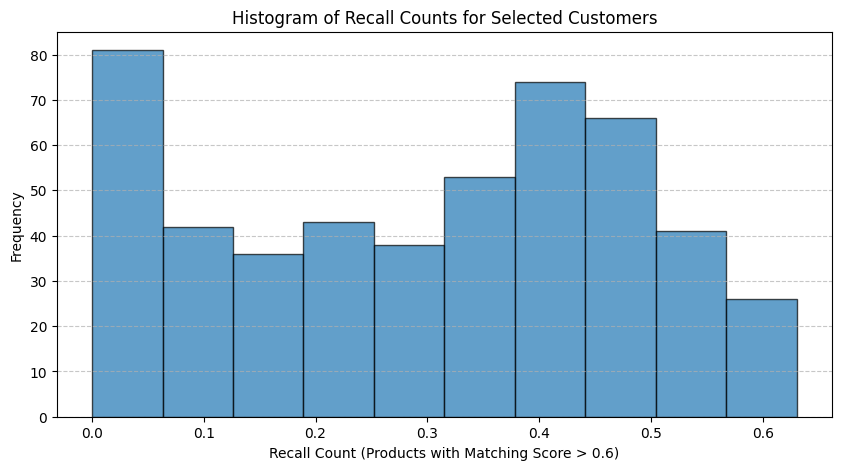

In [ ]:
import matplotlib.pyplot as plt

NUMBER_OF_CUSTOMERS = 500
sample_customers = df["customer_id"].unique()[:NUMBER_OF_CUSTOMERS]  # Get first N unique customer IDs

recall_counts = []  # Store recall counts for plotting

for customer_id_example in sample_customers:
    # Store recall count for histogram
    top_matches, recall_count = get_top_5_matching_products(customer_id_example)
    recall_counts.append(recall_count)

    # print(f"\nRECALL for Customer {customer_id_example}: {recall_count} products with matching score > 0.6")

# Plot histogram of recall counts
plt.figure(figsize=(10, 5))
plt.hist(recall_counts, bins=10, alpha=0.7, edgecolor="black")
plt.xlabel("Recall Count (Products with Matching Score > 0.6)")
plt.ylabel("Frequency")
plt.title("Histogram of Recall Counts for Selected Customers")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()